In [1]:
# Required libraries
import os
import math
import pims
from natsort import natsorted
import torch
import torch.nn as nn
from torch import Tensor
import random
import cv2 as cv
import numpy as np
import pandas as pd
import skimage as ski
from PIL import Image
import statistics
from PIL.ExifTags import TAGS
import matplotlib.pyplot as plt
from typing import Any, Callable, List, Optional, Type, Union
from tqdm import tqdm # for calculating mean, stdev (https://kozodoi.me/blog/20210308/compute-image-stats)
from itertools import islice # for taking first n elements from an iterable (dataloader object)
from torchinfo import summary
import wandb
from datetime import datetime

from torch.utils.data import Dataset, DataLoader, random_split

from torchvision.models import resnet101, ResNet101_Weights, resnet50, ResNet50_Weights
from torchvision.io import read_image
from torchvision.utils import save_image
from torch.utils.checkpoint import checkpoint
from torchvision.transforms import v2 as transforms

from transformers import AutoModel

# from pythae.models import AE, AEConfig, AutoModel
# from pythae.trainers import BaseTrainerConfig
# from pythae.pipelines.training import TrainingPipeline
# from pythae.models.nn.benchmarks.celeba import Encoder_ResNet_AE_CELEBA, Decoder_ResNet_AE_CELEBA, Encoder_Conv_AE_CELEBA, Decoder_Conv_AE_CELEBA, Encoder_ResNet_VAE_CELEBA
# from pythae.data.datasets import DatasetOutput
# from pythae.samplers import NormalSampler
from pythae.trainers.training_callbacks import WandbCallback

os.environ['WANDB_DATA_DIR'] = '/hps/nobackup/birney/users/esther/wandb/artifacts/staging/'
os.environ['WANDB_TIMEOUT'] = '120'
os.environ['JAVA_HOME'] = '/hps/nobackup/birney/users/esther/Fiji.app/java/linux-amd64/zulu8.60.0.21-ca-fx-jdk8.0.322-linux_x64/jre/'

In [2]:
! module load cuda/12.2.0

In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(torch.version.cuda)

12.1


In [4]:
torch.manual_seed(1)

In [5]:
# Set working directory
os.chdir('/nfs/research/birney/users/esther/medaka-img/src_files/')
model_dir = '/hps/nobackup/birney/users/esther/medaka-img/models/'

In [6]:
wandb.login()

wandb: Using wandb-core as the SDK backend. Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: ey267 (ey267-university-of-cambridge). Use `wandb login --relogin` to force relogin


True

## Build the CNN-based autoencoder
Feed a 224x224 image into the autoencoder

In [7]:
class AutoEncoderConv(nn.Module):
    def __init__(self, input_dim, latent_dim):
        super(AutoEncoderConv, self).__init__()
        # encoder
        self.conv1 = nn.Sequential(
            nn.Conv2d(input_dim[0], 128, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU()
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU()
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU()
        )
        self.conv4 = nn.Sequential(
            nn.Conv2d(512, 1024, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(1024),
            nn.ReLU()
        )
        self.embedding = nn.Linear(1024 * 14 * 14, latent_dim)

        # decoder
        self.deconv1 = nn.Sequential(nn.Linear(latent_dim, 1024 * 28 * 28))
        self.deconv2 = nn.Sequential(
            nn.ConvTranspose2d(1024, 512, kernel_size=5, stride=2, padding=2),
            nn.BatchNorm2d(512),
            nn.ReLU()
        )
        self.deconv3 = nn.Sequential(
            nn.ConvTranspose2d(512, 256, kernel_size=5, stride=2, padding=1, output_padding=0),
            nn.BatchNorm2d(256),
            nn.ReLU()
        )
        self.deconv4 = nn.Sequential(
            nn.ConvTranspose2d(256, 128, kernel_size=5, stride=2, padding=2, output_padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU()
        )
        self.deconv5 = nn.Sequential(
                nn.ConvTranspose2d(128, input_dim[0], 5, 1, padding=1), nn.Sigmoid()
        )
    
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.embedding(x.reshape(x.shape[0], -1))
        x = self.deconv1(x)
        x = x.view(-1, 1024, 28, 28)
        x = self.deconv2(x)
        x = self.deconv3(x)
        x = self.deconv4(x)
        x = self.deconv5(x)
        return x

In [8]:
model = AutoEncoderConv((3, 224, 224), 128)

summary(model, input_size=(1, 3, 224, 224))

Layer (type:depth-idx)                   Output Shape              Param #
AutoEncoderConv                          [1, 3, 224, 224]          --
├─Sequential: 1-1                        [1, 128, 112, 112]        --
│    └─Conv2d: 2-1                       [1, 128, 112, 112]        6,272
│    └─BatchNorm2d: 2-2                  [1, 128, 112, 112]        256
│    └─ReLU: 2-3                         [1, 128, 112, 112]        --
├─Sequential: 1-2                        [1, 256, 56, 56]          --
│    └─Conv2d: 2-4                       [1, 256, 56, 56]          524,544
│    └─BatchNorm2d: 2-5                  [1, 256, 56, 56]          512
│    └─ReLU: 2-6                         [1, 256, 56, 56]          --
├─Sequential: 1-3                        [1, 512, 28, 28]          --
│    └─Conv2d: 2-7                       [1, 512, 28, 28]          2,097,664
│    └─BatchNorm2d: 2-8                  [1, 512, 28, 28]          1,024
│    └─ReLU: 2-9                         [1, 512, 28, 28]        

In [9]:
print(*list(model.children())[4:-5])

Linear(in_features=200704, out_features=128, bias=True)


In [10]:
class ConvClassifier(nn.Module):
    def __init__(self, input_dim, latent_dim):
        super(ConvClassifier, self).__init__()

        convnet = AutoEncoderConv(input_dim, latent_dim)

        checkpoint = torch.load(f'{model_dir}/checkpoints/convnet-ae-pytorch-medaka/amber-sweep-1/ckpt-model-convnet-ae-run-amber-sweep-1-epoch-499-time-2024-10-29-1820.pt')
        convnet.load_state_dict(checkpoint['model_state_dict'])
        
        self.encoder = nn.Sequential(*list(convnet.children())[:-6])
        self.embedding = nn.Sequential(*list(convnet.children())[4:-5])

        self.fc1 = nn.Linear(latent_dim, 64)
        self.fc2 = nn.Linear(64, 5)
        self.fc3 = nn.Linear(5, 1)

    def forward(self, x):
        x = self.encoder(x)
        x = self.embedding(x.reshape(x.shape[0], -1))
        x = self.fc1(x)
        x = self.fc2(x)
        x = self.fc3(x)
        return x

In [11]:
model = ConvClassifier((3, 224, 224), 128)

summary(model, input_size=(1, 3, 224, 224))

Layer (type:depth-idx)                   Output Shape              Param #
ConvClassifier                           [1, 1]                    --
├─Sequential: 1-1                        [1, 1024, 14, 14]         --
│    └─Sequential: 2-1                   [1, 128, 112, 112]        --
│    │    └─Conv2d: 3-1                  [1, 128, 112, 112]        6,272
│    │    └─BatchNorm2d: 3-2             [1, 128, 112, 112]        256
│    │    └─ReLU: 3-3                    [1, 128, 112, 112]        --
│    └─Sequential: 2-2                   [1, 256, 56, 56]          --
│    │    └─Conv2d: 3-4                  [1, 256, 56, 56]          524,544
│    │    └─BatchNorm2d: 3-5             [1, 256, 56, 56]          512
│    │    └─ReLU: 3-6                    [1, 256, 56, 56]          --
│    └─Sequential: 2-3                   [1, 512, 28, 28]          --
│    │    └─Conv2d: 3-7                  [1, 512, 28, 28]          2,097,664
│    │    └─BatchNorm2d: 3-8             [1, 512, 28, 28]          1

In [12]:
for idx, param in enumerate(model.parameters()):
    print(idx, param.requires_grad)
    print(param.size())
    param.requires_grad = False
    if (idx > 17): 
        param.requires_grad = True

0 True
torch.Size([128, 3, 4, 4])
1 True
torch.Size([128])
2 True
torch.Size([128])
3 True
torch.Size([128])
4 True
torch.Size([256, 128, 4, 4])
5 True
torch.Size([256])
6 True
torch.Size([256])
7 True
torch.Size([256])
8 True
torch.Size([512, 256, 4, 4])
9 True
torch.Size([512])
10 True
torch.Size([512])
11 True
torch.Size([512])
12 True
torch.Size([1024, 512, 4, 4])
13 True
torch.Size([1024])
14 True
torch.Size([1024])
15 True
torch.Size([1024])
16 True
torch.Size([128, 200704])
17 True
torch.Size([128])
18 True
torch.Size([64, 128])
19 True
torch.Size([64])
20 True
torch.Size([5, 64])
21 True
torch.Size([5])
22 True
torch.Size([1, 5])
23 True
torch.Size([1])


In [64]:
class ConvClassifierPretrained(nn.Module):
    def __init__(self, input_dim, latent_dim):
        super(ConvClassifierPretrained, self).__init__()
        # encoder
        self.encoder = nn.Sequential(
            nn.Sequential(
                nn.Conv2d(input_dim[0], 128, kernel_size=4, stride=2, padding=1),
                nn.BatchNorm2d(128),
                nn.ReLU()
            ),
            nn.Sequential(
                nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1),
                nn.BatchNorm2d(256),
                nn.ReLU()
            ),
            nn.Sequential(
                nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1),
                nn.BatchNorm2d(512),
                nn.ReLU()
            ),
            nn.Sequential(
                nn.Conv2d(512, 1024, kernel_size=4, stride=2, padding=1),
                nn.BatchNorm2d(1024),
                nn.ReLU()
            )
        )
        self.embedding = nn.Sequential(nn.Linear(1024 * 14 * 14, latent_dim))
        self.fc1 = nn.Linear(latent_dim, 64)
        self.fc2 = nn.Linear(64, 5)
        self.fc3 = nn.Linear(5, 1)

    def forward(self, x):
        x = self.encoder(x)
        x = self.embedding(x.reshape(x.shape[0], -1))
        x = self.fc1(x)
        x = self.fc2(x)
        x = self.fc3(x)
        return x

In [65]:
model = ConvClassifierPretrained((3, 224, 224), 128)

summary(model, input_size=(1, 3, 224, 224))

Layer (type:depth-idx)                   Output Shape              Param #
ConvClassifierPretrained                 [1, 1]                    --
├─Sequential: 1-1                        [1, 1024, 14, 14]         --
│    └─Sequential: 2-1                   [1, 128, 112, 112]        --
│    │    └─Conv2d: 3-1                  [1, 128, 112, 112]        6,272
│    │    └─BatchNorm2d: 3-2             [1, 128, 112, 112]        256
│    │    └─ReLU: 3-3                    [1, 128, 112, 112]        --
│    └─Sequential: 2-2                   [1, 256, 56, 56]          --
│    │    └─Conv2d: 3-4                  [1, 256, 56, 56]          524,544
│    │    └─BatchNorm2d: 3-5             [1, 256, 56, 56]          512
│    │    └─ReLU: 3-6                    [1, 256, 56, 56]          --
│    └─Sequential: 2-3                   [1, 512, 28, 28]          --
│    │    └─Conv2d: 3-7                  [1, 512, 28, 28]          2,097,664
│    │    └─BatchNorm2d: 3-8             [1, 512, 28, 28]          1

In [13]:
for idx, param in enumerate(model.parameters()):
    print(idx, param.requires_grad)
    print(param.size())

0 False
torch.Size([128, 3, 4, 4])
1 False
torch.Size([128])
2 False
torch.Size([128])
3 False
torch.Size([128])
4 False
torch.Size([256, 128, 4, 4])
5 False
torch.Size([256])
6 False
torch.Size([256])
7 False
torch.Size([256])
8 False
torch.Size([512, 256, 4, 4])
9 False
torch.Size([512])
10 False
torch.Size([512])
11 False
torch.Size([512])
12 False
torch.Size([1024, 512, 4, 4])
13 False
torch.Size([1024])
14 False
torch.Size([1024])
15 False
torch.Size([1024])
16 False
torch.Size([128, 200704])
17 False
torch.Size([128])
18 True
torch.Size([64, 128])
19 True
torch.Size([64])
20 True
torch.Size([5, 64])
21 True
torch.Size([5])
22 True
torch.Size([1, 5])
23 True
torch.Size([1])


## Configure wandb

In [78]:
config = dict(
    epochs=301,
    batch_size=32,
    learning_rate=0.0000001,
    dataset="medaka-img-2024-10-03",
    architecture="Convolutional NN Autoencoder - predict vertebrae counts",
    model="convnet-ae",
    train_img_rotation=10, # How much to rotate images during training
    ckpt_freq=50, # How often to save model checkpoints
    ckpt_dir=model_dir, # Directory to save model checkpoints
    reconstruction_table_freq=50, # How often to save reconstruction table

)

print(config['batch_size'])

32


## Load medaka data

In [15]:
# Custom min-max scaling function to pass into Compose; transforms pixel values to range [0,1] for each image individually
class MinMaxScaling:
    def __call__(self, tensor):
        return (tensor - tensor.min()) / (tensor.max() - tensor.min())

In [16]:
# Compose image transformations
# Based on testing below, MinMax scaling is the best normalization method for this dataset
# Using mean and std of the dataset for normalization is maybe not representative of the entire dataset,
# as the maximum value after normalization is 431.33228 (eg. subtracting the max pixel value, )
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Lambda(lambda img: transforms.functional.crop(img, 0, 0, 980, 1392)), # crop out bottom text
    transforms.Resize((224, 224)),
    # transforms.Resize((979, 979)), # resize to 979x979 to give 490x490 after first conv
    # transforms.RandomCrop(64), # crop to 64x64
    # transforms.Normalize(mean=(0, 0, 0), std=(1, 1, 1)) # temporarily, to get the mean and stdev of the dataset
    # transforms.Normalize(mean=(0.035028, 0.000052371, 0.00043022), std=(0.0600, 0.0013, 0.0028))
    # transforms.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)), # imagenet normalization -> returns black images
    MinMaxScaling() # custom normalization
])

/hps/software/users/birney/esther/micromamba/envs/indigene-img/lib/python3.9/site-packages/torchvision/transforms/v2/_deprecated.py:42: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.Output is equivalent up to float precision.
  warnings.warn(


Flip all left-facing images to the right within the MedakaDataset class

In [17]:
# Read in dataframe indicating whether the fish is facing left or right
fish_direction_df= pd.read_csv("/nfs/research/birney/users/esther/medaka-img/scripts/left-facing-fish.csv")

# Only keep rows where the fish is facing left
fish_left_df = fish_direction_df[fish_direction_df['left_facing'] == 'left']
fish_left_df = fish_left_df.rename(columns={'Unnamed: 0': 'img_name'})

In [38]:
class MedakaDataset(Dataset):
    def __init__(self, csv_file, src_dir, transform=transform):
        self.image_paths = pd.read_csv(csv_file)['img_name']
        self.abdominal = pd.read_csv(csv_file)['abdominal']
        self.caudal = pd.read_csv(csv_file)['caudal']

        self.src_dir = src_dir
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_name = self.image_paths[idx]
        img_path = f'{self.src_dir}/{img_name}'
        abdominal = torch.tensor(self.abdominal[idx])
        caudal = torch.tensor(self.caudal[idx])
                
        image = ski.io.imread(img_path)

        # Convert to tensor, crop out bottom text, and normalize
        if self.transform is not None:
            image = self.transform(image)

        # If facing left, flip the image horizontally
        if os.path.splitext(img_name)[0] in fish_left_df['img_name'].values:
            image = transforms.functional.hflip(image)

        return image.to(device), img_name, abdominal.to(torch.float), caudal.to(torch.float) # in script cannot use .to(device) here

In [39]:
# Load dataset
dataset = MedakaDataset(csv_file='train_set_2024-10-03.csv', 
                                src_dir='/nfs/research/birney/users/esther/medaka-img/src_files/train_2024-10-03/raw_images', 
                                transform=transform)

train_len = int(len(dataset) * 0.8)
val_len = len(dataset) - train_len

train_dataset, val_dataset = random_split(dataset, [train_len, val_len])

print(f"Total training set length: {len(dataset)}")
print(f"Train length: {train_len}")
print(f"Validation length: {val_len}")

test_dataset = MedakaDataset(csv_file='test_set_2024-10-03 copy.csv',
                                src_dir='/nfs/research/birney/users/esther/medaka-img/src_files/test_2024-10-03/raw_images',
                                transform=transform)
print("Test length: ", len(test_dataset))

Total training set length: 1112
Train length: 889
Validation length: 223
Test length:  1008


In [69]:
print(dataset[0][2] + dataset[0][3])

tensor(30.)


Implement checkpointing

In [22]:
def save_checkpoint(model, optimizer, epoch, filename="checkpoint.pth.tar"):
    checkpoint = {
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict()
    }
    os.makedirs(os.path.dirname(filename), exist_ok=True)
    torch.save(checkpoint, filename)

def load_checkpoint(filename, model, optimizer):
    checkpoint = torch.load(filename)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    return checkpoint['epoch']

## Create training loop

In [23]:
random_trans = transforms.Compose([
        transforms.RandomRotation(config['train_img_rotation'])
    ])

In [79]:
def make(config):
    # Make the data
    train_loader = DataLoader(train_dataset, batch_size=config['batch_size'], shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=config['batch_size'])

    # Make the model
    # model = ConvClassifier((3, 224, 224), 128)
    model = ConvClassifierPretrained((3, 224, 224), 128)
    checkpoint = torch.load("/hps/nobackup/birney/users/esther/medaka-img/models/checkpoints/convnet-ae-pytorch-medaka/fresh-resonance-35/ckpt-model-convnet-ae-run-fresh-resonance-35-epoch-300-val_loss-6.73119.pt")
    # checkpoint = torch.load("/hps/nobackup/birney/users/esther/medaka-img/models/checkpoints/convnet-ae-pytorch-medaka/morning-violet-31/ckpt-model-convnet-ae-run-morning-violet-31-epoch-200-val_loss-4.51547.pt")
    model.load_state_dict(checkpoint['model_state_dict'])
    for idx, param in enumerate(model.parameters()):
        param.requires_grad = False
        if (idx > 17): 
            param.requires_grad = True
    model.to(device)
    # model = AutoEncoder(num_input, num_hidden_0, num_hidden_1, num_hidden_2, num_hidden_3, num_hidden_4).to(device)

    # Make the loss and optimizer
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(
        model.parameters(), lr=config['learning_rate'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    
    return model, train_loader, val_loader, criterion, optimizer

In [76]:
def train(model, train_loader, val_loader, criterion, optimizer, run_name, config):
    # Tell wandb to watch what the model gets up to: gradients, weights, and more!
    wandb.watch(model, criterion, log="all", log_freq=10)

    # Create wandb table
    columns = ["epoch", "id", "num_vertebrae", "predicted_vertebrae"]
    test_table = wandb.Table(columns=columns)

    # Run training and track with wandb
    example_ct = 0  # number of examples seen
    batch_ct = 0

    for epoch in tqdm(range(config['epochs'])):
        model.train()
        for image, image_name, abdominal, caudal in train_loader:
            image = random_trans(image)
            # image = torch.reshape(random_trans(image),(-1, 224*224))
            train_loss = train_batch(image, (abdominal + caudal), model, optimizer, criterion)
            example_ct +=  len(image) # the batch size
            batch_ct += 1

        train_log(train_loss, example_ct, epoch)

        model.eval()
        with torch.no_grad():
            val_loss = 0.0
            for image, image_name, abdominal, caudal in val_loader:
                # image = torch.reshape(image,(-1, 224*224))
                image = random_trans(image)
                image = image.to(device)
                output = model(image)
                loss = criterion(output.to(device), (abdominal + caudal).to(device))
                val_loss += loss.item()

            val_loss /= len(val_loader)
            wandb.log({"val_loss": val_loss}, step=epoch)
            print(f"Validation loss: {val_loss:.5f}")
            
        # Every 20th epoch, save model checkpoint
        if (epoch == config['epochs'] - 1) or (epoch % 100 == 0) and (epoch != 0):
            # date_time = datetime.now().strftime("%Y%m%d%H%M%S")
            ckpt_name = f"ckpt-model-{config['model']}-run-{run_name}-epoch-{epoch}-val_loss-{val_loss:.5f}"    

            # save_checkpoint(model, optimizer, epoch, filename=f'{model_dir}/checkpoints/vanilla-ae-pytorch-medaka/{ckpt_name}-{date_time}.pt')
            save_checkpoint(model, optimizer, epoch, filename=f'{model_dir}/checkpoints/convnet-ae-pytorch-medaka/{run_name}/{ckpt_name}.pt')

        #     # model_checkpoint = wandb.Artifact(
        #     #     name=ckpt_name,
        #     #     type="model").add_file(local_path=f'{model_dir}/checkpoints/vanilla-ae-pytorch-medaka/{ckpt_name}-{date_time}.pt')

        #     # assert isinstance(model_checkpoint, wandb.Artifact), "model_checkpoint is not a wandb.Artifact"

        #     wandb.log_artifact(
        #         artifact_or_path=f'{model_dir}/checkpoints/vanilla-ae-pytorch-medaka/{run_name}/{ckpt_name}.pt', 
        #         type="model-checkpoint",
        #         aliases=[f"model={config['model']}", f"architecture={config['architecture']}", f"epoch={epoch}", f"run={run_name}"])   


        # Every 50th epoch, output image reconstruction
        if (epoch % 5 == 0):
            print("Logging table at epoch", epoch)
            show_img, id, abdominal, caudal = val_dataset[0]
            show_img = show_img.unsqueeze(0)
            output = model(show_img.to(device)).cpu().detach().to(torch.float32)
            # recon_img = model(show_img.to(device)).cpu().detach().to(torch.float32)
            test_table.add_data(epoch, id, (abdominal + caudal), output.item())
            test_table = wandb.Table(columns=columns, data=test_table.data)
            wandb.log({"Vertebrae classification performance": test_table})


def train_batch(image, count, model, optimizer, criterion):
    image = image.to(device)
    
    # Forward pass
    output = torch.squeeze(model(image))
    loss = criterion(output.to(device), count.to(device))
    
    # Backward pass
    optimizer.zero_grad()
    loss.backward()

    # Step with optimizer
    optimizer.step()

    return loss

def train_log(loss, example_ct, epoch):
    # Where the magic happens
    wandb.log({"epoch": epoch, "train loss": loss}, step=epoch)
    print(f"Loss after {str(example_ct).zfill(5)} examples: {loss:.5f}")

In [57]:

def test(model, test_loader, criterion):
    wandb.define_metric("img_name")
    wandb.define_metric("test_loss", step_metric="img_name")
    columns = ["id", "image", "reconstructed"]
    test_set_table = wandb.Table(columns=columns)

    model.eval()

    # Run the model on some test examples
    with torch.no_grad():
        counter = 0
        for image, image_name in test_loader:
            image = image.to(device)
            output = model(image)
            loss = criterion(output, image)
            counter += 1
            log_dict = {"img_name": image_name, 
                        "test_loss": loss
                }

            print(f"Test Loss: {loss:.6f}")
            wandb.log(log_dict)

            if counter % 10 == 0:
                print("Logging table for image ", image_name)
                show_img = image
                recon_img = model(show_img.to(device)).cpu().detach().to(torch.float32)
                test_set_table.add_data(image_name, wandb.Image(show_img), wandb.Image(recon_img))
                test_set_table = wandb.Table(columns=columns, data=test_set_table.data)
                wandb.log({"Image reconstruction performance": test_set_table})
        
        # wandb.log({"vali": correct / total})

    # Save the model in the exchangeable ONNX format
    # torch.onnx.export(model, image, "model.onnx")
    # wandb.save("model.onnx")

In [66]:
model = AutoEncoderConv((3, 224, 224), 128).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

checkpoint = torch.load(f'{model_dir}/checkpoints/convnet-ae-pytorch-medaka/amber-sweep-1/ckpt-model-convnet-ae-run-amber-sweep-1-epoch-499-time-2024-10-29-1820.pt')
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
epoch = checkpoint['epoch']
criterion = nn.MSELoss()

test_loader = DataLoader(test_dataset, batch_size=1, shuffle=True)

In [28]:
def model_pipeline(hyperparameters):
    run = wandb.init(project="convnet-ae-pytorch-medaka", config=hyperparameters)
    # tell wandb to get started
    with run:
      run_name = run.name
      # make the model, data, and optimization problem
      model, train_loader, val_loader, criterion, optimizer = make(hyperparameters)

      # and use them to train the model
      train(model, train_loader, val_loader, criterion, optimizer, run_name, hyperparameters)

      # and test its final performance
      # test(model, test_loader, nn.CrossEntropyLoss())

    run.finish()

    return model, run_name

In [80]:
os.environ["CUDA_LAUNCH_BLOCKING"] = "1"
model, run_name = model_pipeline(config)

torch.cuda.empty_cache()
print(run_name)

  0%|          | 0/301 [00:00<?, ?it/s]

Loss after 00889 examples: 3.54618


/hps/software/users/birney/esther/micromamba/envs/indigene-img/lib/python3.9/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/hps/software/users/birney/esther/micromamba/envs/indigene-img/lib/python3.9/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([31])) that is different to the input size (torch.Size([31, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Validation loss: 6.70740
Logging table at epoch 0


  0%|          | 1/301 [00:05<27:05,  5.42s/it]

Loss after 01778 examples: 6.13343


  1%|          | 2/301 [00:10<25:02,  5.03s/it]

Validation loss: 6.31914
Loss after 02667 examples: 6.43655


  1%|          | 3/301 [00:14<24:00,  4.83s/it]

Validation loss: 6.61718
Loss after 03556 examples: 8.86442


  1%|▏         | 4/301 [00:19<23:42,  4.79s/it]

Validation loss: 7.11964
Loss after 04445 examples: 5.14659


  2%|▏         | 5/301 [00:24<23:17,  4.72s/it]

Validation loss: 5.56779
Loss after 05334 examples: 5.64664
Validation loss: 7.57910
Logging table at epoch 5


  2%|▏         | 6/301 [00:28<23:28,  4.77s/it]

Loss after 06223 examples: 2.75406


  2%|▏         | 7/301 [00:33<23:18,  4.76s/it]

Validation loss: 6.36538
Loss after 07112 examples: 6.20380


  3%|▎         | 8/301 [00:38<23:05,  4.73s/it]

Validation loss: 6.89377
Loss after 08001 examples: 10.22134


  3%|▎         | 9/301 [00:43<22:59,  4.72s/it]

Validation loss: 6.24487
Loss after 08890 examples: 6.07682


  3%|▎         | 10/301 [00:47<22:55,  4.73s/it]

Validation loss: 6.50126
Loss after 09779 examples: 2.85434
Validation loss: 6.77053
Logging table at epoch 10


  4%|▎         | 11/301 [00:52<23:06,  4.78s/it]

Loss after 10668 examples: 4.19314


  4%|▍         | 12/301 [00:57<22:56,  4.76s/it]

Validation loss: 6.37347
Loss after 11557 examples: 4.31361


  4%|▍         | 13/301 [01:02<22:40,  4.73s/it]

Validation loss: 6.62985
Loss after 12446 examples: 4.23672


  5%|▍         | 14/301 [01:06<22:34,  4.72s/it]

Validation loss: 7.04550
Loss after 13335 examples: 8.28468


  5%|▍         | 15/301 [01:11<22:16,  4.67s/it]

Validation loss: 6.53389
Loss after 14224 examples: 8.16170
Validation loss: 7.67533
Logging table at epoch 15


  5%|▌         | 16/301 [01:16<22:30,  4.74s/it]

Loss after 15113 examples: 7.60440


  6%|▌         | 17/301 [01:20<22:19,  4.72s/it]

Validation loss: 6.53332
Loss after 16002 examples: 12.48705


  6%|▌         | 18/301 [01:25<22:10,  4.70s/it]

Validation loss: 7.43520
Loss after 16891 examples: 7.59782


  6%|▋         | 19/301 [01:30<21:58,  4.67s/it]

Validation loss: 7.15581
Loss after 17780 examples: 5.15904


  7%|▋         | 20/301 [01:34<21:55,  4.68s/it]

Validation loss: 7.61657
Loss after 18669 examples: 4.27729
Validation loss: 6.56096
Logging table at epoch 20


  7%|▋         | 21/301 [01:39<22:19,  4.78s/it]

Loss after 19558 examples: 5.71383


  7%|▋         | 22/301 [01:44<21:57,  4.72s/it]

Validation loss: 6.54895
Loss after 20447 examples: 5.24954


  8%|▊         | 23/301 [01:49<21:54,  4.73s/it]

Validation loss: 6.82153
Loss after 21336 examples: 5.32033


  8%|▊         | 24/301 [01:53<21:40,  4.69s/it]

Validation loss: 6.85434
Loss after 22225 examples: 4.28822


  8%|▊         | 25/301 [01:58<21:38,  4.70s/it]

Validation loss: 6.57839
Loss after 23114 examples: 7.25984


  9%|▊         | 26/301 [02:03<21:39,  4.72s/it]

Validation loss: 6.20096
Logging table at epoch 25
Loss after 24003 examples: 7.71101


  9%|▉         | 27/301 [02:07<21:29,  4.71s/it]

Validation loss: 6.93088
Loss after 24892 examples: 4.54933


  9%|▉         | 28/301 [02:12<21:10,  4.65s/it]

Validation loss: 6.26154
Loss after 25781 examples: 5.32195


 10%|▉         | 29/301 [02:17<21:07,  4.66s/it]

Validation loss: 6.82083
Loss after 26670 examples: 3.81400


 10%|▉         | 30/301 [02:21<21:03,  4.66s/it]

Validation loss: 6.27865
Loss after 27559 examples: 9.42275


 10%|█         | 31/301 [02:26<21:13,  4.72s/it]

Validation loss: 8.03910
Logging table at epoch 30
Loss after 28448 examples: 3.10377


 11%|█         | 32/301 [02:31<20:58,  4.68s/it]

Validation loss: 6.81624
Loss after 29337 examples: 5.02199


 11%|█         | 33/301 [02:35<20:53,  4.68s/it]

Validation loss: 7.05680
Loss after 30226 examples: 6.53050


 11%|█▏        | 34/301 [02:40<20:41,  4.65s/it]

Validation loss: 6.17189
Loss after 31115 examples: 4.34232


 12%|█▏        | 35/301 [02:45<20:41,  4.67s/it]

Validation loss: 6.99802
Loss after 32004 examples: 7.70938


 12%|█▏        | 36/301 [02:50<20:48,  4.71s/it]

Validation loss: 6.98170
Logging table at epoch 35
Loss after 32893 examples: 6.45170


 12%|█▏        | 37/301 [02:54<20:42,  4.71s/it]

Validation loss: 7.65817
Loss after 33782 examples: 6.31953


 13%|█▎        | 38/301 [02:59<20:32,  4.69s/it]

Validation loss: 7.12432
Loss after 34671 examples: 6.25838


 13%|█▎        | 39/301 [03:04<20:37,  4.73s/it]

Validation loss: 6.76315
Loss after 35560 examples: 5.62143


 13%|█▎        | 40/301 [03:08<20:28,  4.71s/it]

Validation loss: 6.46052
Loss after 36449 examples: 5.71884
Validation loss: 6.08693
Logging table at epoch 40


 14%|█▎        | 41/301 [03:13<20:45,  4.79s/it]

Loss after 37338 examples: 5.29576


 14%|█▍        | 42/301 [03:18<20:38,  4.78s/it]

Validation loss: 7.35983
Loss after 38227 examples: 4.98080


 14%|█▍        | 43/301 [03:23<20:39,  4.81s/it]

Validation loss: 5.87894
Loss after 39116 examples: 5.81494


 15%|█▍        | 44/301 [03:28<20:24,  4.76s/it]

Validation loss: 5.49244
Loss after 40005 examples: 3.54406


 15%|█▍        | 45/301 [03:32<20:18,  4.76s/it]

Validation loss: 5.91392
Loss after 40894 examples: 3.81547
Validation loss: 6.45125
Logging table at epoch 45


 15%|█▌        | 46/301 [03:37<20:33,  4.84s/it]

Loss after 41783 examples: 5.67714


 16%|█▌        | 47/301 [03:42<20:17,  4.79s/it]

Validation loss: 7.44392
Loss after 42672 examples: 5.79025


 16%|█▌        | 48/301 [03:47<20:08,  4.78s/it]

Validation loss: 6.05646
Loss after 43561 examples: 4.64692


 16%|█▋        | 49/301 [03:52<19:57,  4.75s/it]

Validation loss: 7.29162
Loss after 44450 examples: 8.20778


 17%|█▋        | 50/301 [03:56<19:55,  4.76s/it]

Validation loss: 6.87719
Loss after 45339 examples: 3.76726
Validation loss: 7.08694
Logging table at epoch 50


 17%|█▋        | 51/301 [04:01<20:02,  4.81s/it]

Loss after 46228 examples: 10.21383


 17%|█▋        | 52/301 [04:06<19:54,  4.80s/it]

Validation loss: 8.08515
Loss after 47117 examples: 5.50613


 18%|█▊        | 53/301 [04:11<19:42,  4.77s/it]

Validation loss: 5.99275
Loss after 48006 examples: 7.51229


 18%|█▊        | 54/301 [04:15<19:32,  4.75s/it]

Validation loss: 7.10773
Loss after 48895 examples: 4.43114


 18%|█▊        | 55/301 [04:20<19:25,  4.74s/it]

Validation loss: 7.17508
Loss after 49784 examples: 6.58545


 19%|█▊        | 56/301 [04:25<19:35,  4.80s/it]

Validation loss: 5.93483
Logging table at epoch 55
Loss after 50673 examples: 4.75737


 19%|█▉        | 57/301 [04:30<19:25,  4.78s/it]

Validation loss: 6.46573
Loss after 51562 examples: 3.92201


 19%|█▉        | 58/301 [04:35<19:24,  4.79s/it]

Validation loss: 6.39470
Loss after 52451 examples: 5.94612


 20%|█▉        | 59/301 [04:39<19:13,  4.77s/it]

Validation loss: 6.18834
Loss after 53340 examples: 3.03906


 20%|█▉        | 60/301 [04:44<19:03,  4.74s/it]

Validation loss: 6.75165
Loss after 54229 examples: 5.43625
Validation loss: 6.96214
Logging table at epoch 60


 20%|██        | 61/301 [04:49<19:13,  4.80s/it]

Loss after 55118 examples: 6.17832


 21%|██        | 62/301 [04:54<19:00,  4.77s/it]

Validation loss: 6.58316
Loss after 56007 examples: 9.99833


 21%|██        | 63/301 [04:58<18:42,  4.71s/it]

Validation loss: 6.07358
Loss after 56896 examples: 4.59162


 21%|██▏       | 64/301 [05:03<18:34,  4.70s/it]

Validation loss: 6.59945
Loss after 57785 examples: 7.89168


 22%|██▏       | 65/301 [05:08<18:21,  4.67s/it]

Validation loss: 6.97154
Loss after 58674 examples: 4.90930


 22%|██▏       | 66/301 [05:12<18:32,  4.73s/it]

Validation loss: 6.56638
Logging table at epoch 65
Loss after 59563 examples: 5.06380


 22%|██▏       | 67/301 [05:17<18:16,  4.69s/it]

Validation loss: 6.28203
Loss after 60452 examples: 4.65777


 23%|██▎       | 68/301 [05:22<18:15,  4.70s/it]

Validation loss: 6.54347
Loss after 61341 examples: 4.17874


 23%|██▎       | 69/301 [05:26<18:12,  4.71s/it]

Validation loss: 7.19297
Loss after 62230 examples: 3.94307


 23%|██▎       | 70/301 [05:31<18:02,  4.69s/it]

Validation loss: 7.79585
Loss after 63119 examples: 6.52270
Validation loss: 6.30589
Logging table at epoch 70


 24%|██▎       | 71/301 [05:36<18:08,  4.73s/it]

Loss after 64008 examples: 5.56689


 24%|██▍       | 72/301 [05:41<17:55,  4.70s/it]

Validation loss: 6.21924
Loss after 64897 examples: 5.38494


 24%|██▍       | 73/301 [05:45<17:46,  4.68s/it]

Validation loss: 5.83297
Loss after 65786 examples: 10.11095


 25%|██▍       | 74/301 [05:50<17:41,  4.67s/it]

Validation loss: 6.94121
Loss after 66675 examples: 5.26374


 25%|██▍       | 75/301 [05:54<17:35,  4.67s/it]

Validation loss: 6.24214
Loss after 67564 examples: 6.08634
Validation loss: 5.81109
Logging table at epoch 75


 25%|██▌       | 76/301 [05:59<17:41,  4.72s/it]

Loss after 68453 examples: 7.89036


 26%|██▌       | 77/301 [06:04<17:31,  4.70s/it]

Validation loss: 7.06585
Loss after 69342 examples: 3.02948


 26%|██▌       | 78/301 [06:08<17:15,  4.64s/it]

Validation loss: 7.42320
Loss after 70231 examples: 7.75881


 26%|██▌       | 79/301 [06:13<17:13,  4.65s/it]

Validation loss: 6.52075
Loss after 71120 examples: 6.85183


 27%|██▋       | 80/301 [06:18<17:03,  4.63s/it]

Validation loss: 7.96107
Loss after 72009 examples: 3.72149
Validation loss: 7.49224
Logging table at epoch 80


 27%|██▋       | 81/301 [06:23<17:20,  4.73s/it]

Loss after 72898 examples: 6.07134


 27%|██▋       | 82/301 [06:27<17:12,  4.71s/it]

Validation loss: 6.62004
Loss after 73787 examples: 6.23128


 28%|██▊       | 83/301 [06:32<17:05,  4.70s/it]

Validation loss: 7.84682
Loss after 74676 examples: 7.24540


 28%|██▊       | 84/301 [06:37<16:51,  4.66s/it]

Validation loss: 5.80328
Loss after 75565 examples: 3.55796


 28%|██▊       | 85/301 [06:41<16:47,  4.67s/it]

Validation loss: 6.65362
Loss after 76454 examples: 8.15364


 29%|██▊       | 86/301 [06:46<16:47,  4.69s/it]

Validation loss: 5.87059
Logging table at epoch 85
Loss after 77343 examples: 9.14034


 29%|██▉       | 87/301 [06:51<16:50,  4.72s/it]

Validation loss: 6.09251
Loss after 78232 examples: 4.89455


 29%|██▉       | 88/301 [06:55<16:39,  4.69s/it]

Validation loss: 6.53627
Loss after 79121 examples: 2.47359


 30%|██▉       | 89/301 [07:00<16:43,  4.73s/it]

Validation loss: 6.26582
Loss after 80010 examples: 3.01409


 30%|██▉       | 90/301 [07:05<16:30,  4.69s/it]

Validation loss: 6.44525
Loss after 80899 examples: 8.07854
Validation loss: 6.19294
Logging table at epoch 90


 30%|███       | 91/301 [07:10<16:34,  4.74s/it]

Loss after 81788 examples: 7.86039


 31%|███       | 92/301 [07:14<16:21,  4.69s/it]

Validation loss: 6.52096
Loss after 82677 examples: 5.20400


 31%|███       | 93/301 [07:19<16:19,  4.71s/it]

Validation loss: 6.39651
Loss after 83566 examples: 3.94104


 31%|███       | 94/301 [07:24<16:07,  4.67s/it]

Validation loss: 7.91187
Loss after 84455 examples: 8.72814


 32%|███▏      | 95/301 [07:28<16:04,  4.68s/it]

Validation loss: 6.76107
Loss after 85344 examples: 3.99714
Validation loss: 6.23843
Logging table at epoch 95


 32%|███▏      | 96/301 [07:33<16:18,  4.77s/it]

Loss after 86233 examples: 4.76873


 32%|███▏      | 97/301 [07:38<16:08,  4.75s/it]

Validation loss: 6.21053
Loss after 87122 examples: 5.73961


 33%|███▎      | 98/301 [07:43<16:01,  4.73s/it]

Validation loss: 6.93965
Loss after 88011 examples: 4.89010


 33%|███▎      | 99/301 [07:47<15:52,  4.71s/it]

Validation loss: 6.13853
Loss after 88900 examples: 5.95809


 33%|███▎      | 100/301 [07:52<15:52,  4.74s/it]

Validation loss: 6.68158
Loss after 89789 examples: 5.89222
Validation loss: 6.10061
Logging table at epoch 100


 34%|███▎      | 101/301 [07:57<16:09,  4.85s/it]

Loss after 90678 examples: 11.25935


 34%|███▍      | 102/301 [08:02<16:01,  4.83s/it]

Validation loss: 6.59213
Loss after 91567 examples: 5.69613


 34%|███▍      | 103/301 [08:07<15:57,  4.84s/it]

Validation loss: 6.88373
Loss after 92456 examples: 6.47076


 35%|███▍      | 104/301 [08:12<15:40,  4.77s/it]

Validation loss: 7.33156
Loss after 93345 examples: 4.69302


 35%|███▍      | 105/301 [08:16<15:21,  4.70s/it]

Validation loss: 7.37520
Loss after 94234 examples: 2.79091
Validation loss: 6.45483
Logging table at epoch 105


 35%|███▌      | 106/301 [08:21<15:29,  4.77s/it]

Loss after 95123 examples: 6.59910


 36%|███▌      | 107/301 [08:26<15:11,  4.70s/it]

Validation loss: 6.06516
Loss after 96012 examples: 7.82849


 36%|███▌      | 108/301 [08:30<15:02,  4.68s/it]

Validation loss: 6.76050
Loss after 96901 examples: 7.44150


 36%|███▌      | 109/301 [08:35<14:51,  4.64s/it]

Validation loss: 6.65583
Loss after 97790 examples: 3.97317


 37%|███▋      | 110/301 [08:39<14:50,  4.66s/it]

Validation loss: 5.61453
Loss after 98679 examples: 4.86762
Validation loss: 7.19103
Logging table at epoch 110


 37%|███▋      | 111/301 [08:44<14:49,  4.68s/it]

Loss after 99568 examples: 4.00642


 37%|███▋      | 112/301 [08:49<14:49,  4.70s/it]

Validation loss: 6.77131
Loss after 100457 examples: 4.88151


 38%|███▊      | 113/301 [08:54<14:36,  4.66s/it]

Validation loss: 5.97270
Loss after 101346 examples: 6.76674


 38%|███▊      | 114/301 [08:58<14:30,  4.65s/it]

Validation loss: 6.54215
Loss after 102235 examples: 5.09132


 38%|███▊      | 115/301 [09:03<14:20,  4.63s/it]

Validation loss: 6.28124
Loss after 103124 examples: 6.50903
Validation loss: 5.83403
Logging table at epoch 115


 39%|███▊      | 116/301 [09:08<14:29,  4.70s/it]

Loss after 104013 examples: 3.99192


 39%|███▉      | 117/301 [09:12<14:15,  4.65s/it]

Validation loss: 5.97580
Loss after 104902 examples: 4.71221


 39%|███▉      | 118/301 [09:17<14:09,  4.64s/it]

Validation loss: 7.74004
Loss after 105791 examples: 6.19191


 40%|███▉      | 119/301 [09:21<14:05,  4.64s/it]

Validation loss: 6.16143
Loss after 106680 examples: 9.81065


 40%|███▉      | 120/301 [09:26<14:01,  4.65s/it]

Validation loss: 7.64639
Loss after 107569 examples: 6.46142
Validation loss: 7.23084
Logging table at epoch 120


 40%|████      | 121/301 [09:31<14:07,  4.71s/it]

Loss after 108458 examples: 4.31102


 41%|████      | 122/301 [09:35<13:56,  4.67s/it]

Validation loss: 7.39481
Loss after 109347 examples: 8.12937


 41%|████      | 123/301 [09:40<13:48,  4.65s/it]

Validation loss: 5.96658
Loss after 110236 examples: 8.54284


 41%|████      | 124/301 [09:45<13:40,  4.64s/it]

Validation loss: 7.84458
Loss after 111125 examples: 3.78862


 42%|████▏     | 125/301 [09:49<13:42,  4.67s/it]

Validation loss: 7.35542
Loss after 112014 examples: 7.63059


 42%|████▏     | 126/301 [09:54<13:38,  4.68s/it]

Validation loss: 5.87957
Logging table at epoch 125
Loss after 112903 examples: 8.06015


 42%|████▏     | 127/301 [09:59<13:30,  4.66s/it]

Validation loss: 6.32928
Loss after 113792 examples: 6.70329


 43%|████▎     | 128/301 [10:03<13:21,  4.63s/it]

Validation loss: 7.44824
Loss after 114681 examples: 6.09463


 43%|████▎     | 129/301 [10:08<13:15,  4.63s/it]

Validation loss: 8.56974
Loss after 115570 examples: 2.33377


 43%|████▎     | 130/301 [10:12<13:04,  4.59s/it]

Validation loss: 6.47626
Loss after 116459 examples: 5.96248


 44%|████▎     | 131/301 [10:17<13:08,  4.64s/it]

Validation loss: 6.91613
Logging table at epoch 130
Loss after 117348 examples: 5.16225


 44%|████▍     | 132/301 [10:22<13:02,  4.63s/it]

Validation loss: 6.54650
Loss after 118237 examples: 3.99736


 44%|████▍     | 133/301 [10:26<12:58,  4.63s/it]

Validation loss: 6.31349
Loss after 119126 examples: 6.15264


 45%|████▍     | 134/301 [10:31<12:47,  4.59s/it]

Validation loss: 7.50666
Loss after 120015 examples: 3.66100


 45%|████▍     | 135/301 [10:36<12:42,  4.59s/it]

Validation loss: 7.82173
Loss after 120904 examples: 3.82770
Validation loss: 7.00582
Logging table at epoch 135


 45%|████▌     | 136/301 [10:40<12:53,  4.68s/it]

Loss after 121793 examples: 5.14691


 46%|████▌     | 137/301 [10:45<12:45,  4.67s/it]

Validation loss: 6.07170
Loss after 122682 examples: 7.24047


 46%|████▌     | 138/301 [10:50<12:36,  4.64s/it]

Validation loss: 6.37059
Loss after 123571 examples: 5.07007


 46%|████▌     | 139/301 [10:54<12:32,  4.65s/it]

Validation loss: 6.17924
Loss after 124460 examples: 4.59887


 47%|████▋     | 140/301 [10:59<12:26,  4.63s/it]

Validation loss: 6.10826
Loss after 125349 examples: 5.50577
Validation loss: 6.49310
Logging table at epoch 140


 47%|████▋     | 141/301 [11:04<12:29,  4.68s/it]

Loss after 126238 examples: 3.60733


 47%|████▋     | 142/301 [11:08<12:22,  4.67s/it]

Validation loss: 5.92475
Loss after 127127 examples: 6.08911


 48%|████▊     | 143/301 [11:13<12:16,  4.66s/it]

Validation loss: 5.93489
Loss after 128016 examples: 6.37384


 48%|████▊     | 144/301 [11:18<12:09,  4.65s/it]

Validation loss: 6.29448
Loss after 128905 examples: 4.47951


 48%|████▊     | 145/301 [11:22<12:07,  4.66s/it]

Validation loss: 7.05450
Loss after 129794 examples: 4.56382
Validation loss: 6.81981
Logging table at epoch 145


 49%|████▊     | 146/301 [11:27<12:09,  4.71s/it]

Loss after 130683 examples: 6.38420


 49%|████▉     | 147/301 [11:32<11:56,  4.65s/it]

Validation loss: 6.11593
Loss after 131572 examples: 5.69676


 49%|████▉     | 148/301 [11:36<11:51,  4.65s/it]

Validation loss: 7.24302
Loss after 132461 examples: 4.40879


 50%|████▉     | 149/301 [11:41<11:42,  4.62s/it]

Validation loss: 6.44217
Loss after 133350 examples: 3.94979


 50%|████▉     | 150/301 [11:45<11:38,  4.63s/it]

Validation loss: 6.52288
Loss after 134239 examples: 4.33008
Validation loss: 6.13757
Logging table at epoch 150


 50%|█████     | 151/301 [11:50<11:44,  4.70s/it]

Loss after 135128 examples: 3.82685


 50%|█████     | 152/301 [11:55<11:38,  4.69s/it]

Validation loss: 7.43726
Loss after 136017 examples: 3.77456


 51%|█████     | 153/301 [12:00<11:28,  4.65s/it]

Validation loss: 6.34298
Loss after 136906 examples: 7.90263


 51%|█████     | 154/301 [12:04<11:23,  4.65s/it]

Validation loss: 5.93121
Loss after 137795 examples: 4.16780


 51%|█████▏    | 155/301 [12:09<11:13,  4.61s/it]

Validation loss: 6.42932
Loss after 138684 examples: 6.37646
Validation loss: 7.60301
Logging table at epoch 155


 52%|█████▏    | 156/301 [12:14<11:18,  4.68s/it]

Loss after 139573 examples: 4.56007


 52%|█████▏    | 157/301 [12:18<11:06,  4.63s/it]

Validation loss: 6.60963
Loss after 140462 examples: 7.98290


 52%|█████▏    | 158/301 [12:23<11:01,  4.63s/it]

Validation loss: 6.18845
Loss after 141351 examples: 5.29935


 53%|█████▎    | 159/301 [12:27<10:53,  4.61s/it]

Validation loss: 6.51697
Loss after 142240 examples: 3.64567


 53%|█████▎    | 160/301 [12:32<10:50,  4.61s/it]

Validation loss: 6.96078
Loss after 143129 examples: 5.68028


 53%|█████▎    | 161/301 [12:37<10:57,  4.69s/it]

Validation loss: 6.57091
Logging table at epoch 160
Loss after 144018 examples: 2.80636


 54%|█████▍    | 162/301 [12:41<10:48,  4.67s/it]

Validation loss: 6.86984
Loss after 144907 examples: 4.84952


 54%|█████▍    | 163/301 [12:46<10:41,  4.65s/it]

Validation loss: 6.35720
Loss after 145796 examples: 9.77916


 54%|█████▍    | 164/301 [12:51<10:40,  4.67s/it]

Validation loss: 7.95291
Loss after 146685 examples: 6.98700


 55%|█████▍    | 165/301 [12:55<10:30,  4.64s/it]

Validation loss: 6.06492
Loss after 147574 examples: 8.34789
Validation loss: 6.54776
Logging table at epoch 165


 55%|█████▌    | 166/301 [13:00<10:34,  4.70s/it]

Loss after 148463 examples: 3.90535


 55%|█████▌    | 167/301 [13:05<10:23,  4.66s/it]

Validation loss: 6.39428
Loss after 149352 examples: 5.07918


 56%|█████▌    | 168/301 [13:09<10:17,  4.64s/it]

Validation loss: 6.54445
Loss after 150241 examples: 8.24343


 56%|█████▌    | 169/301 [13:14<10:11,  4.63s/it]

Validation loss: 7.51273
Loss after 151130 examples: 3.27549


 56%|█████▋    | 170/301 [13:19<10:12,  4.68s/it]

Validation loss: 6.77760
Loss after 152019 examples: 7.59237
Validation loss: 5.75922
Logging table at epoch 170


 57%|█████▋    | 171/301 [13:24<10:14,  4.73s/it]

Loss after 152908 examples: 5.50282


 57%|█████▋    | 172/301 [13:28<10:04,  4.68s/it]

Validation loss: 6.61130
Loss after 153797 examples: 2.10972


 57%|█████▋    | 173/301 [13:33<10:00,  4.69s/it]

Validation loss: 5.93724
Loss after 154686 examples: 8.17434


 58%|█████▊    | 174/301 [13:37<09:51,  4.66s/it]

Validation loss: 6.14368
Loss after 155575 examples: 7.18364


 58%|█████▊    | 175/301 [13:42<09:47,  4.67s/it]

Validation loss: 7.44695
Loss after 156464 examples: 7.37595
Validation loss: 7.23236
Logging table at epoch 175


 58%|█████▊    | 176/301 [13:47<09:47,  4.70s/it]

Loss after 157353 examples: 5.75358


 59%|█████▉    | 177/301 [13:52<09:43,  4.71s/it]

Validation loss: 5.99661
Loss after 158242 examples: 4.35885


 59%|█████▉    | 178/301 [13:56<09:33,  4.66s/it]

Validation loss: 6.34941
Loss after 159131 examples: 4.46579


 59%|█████▉    | 179/301 [14:01<09:27,  4.65s/it]

Validation loss: 6.24927
Loss after 160020 examples: 5.03690


 60%|█████▉    | 180/301 [14:05<09:19,  4.62s/it]

Validation loss: 6.64309
Loss after 160909 examples: 7.68061
Validation loss: 5.71437
Logging table at epoch 180


 60%|██████    | 181/301 [14:10<09:23,  4.70s/it]

Loss after 161798 examples: 5.86975


 60%|██████    | 182/301 [14:15<09:15,  4.67s/it]

Validation loss: 6.37967
Loss after 162687 examples: 5.51628


 61%|██████    | 183/301 [14:19<09:12,  4.68s/it]

Validation loss: 6.40603
Loss after 163576 examples: 3.12827


 61%|██████    | 184/301 [14:24<09:02,  4.63s/it]

Validation loss: 6.40844
Loss after 164465 examples: 8.54431


 61%|██████▏   | 185/301 [14:29<08:56,  4.62s/it]

Validation loss: 6.59047
Loss after 165354 examples: 3.80246
Validation loss: 8.43646
Logging table at epoch 185


 62%|██████▏   | 186/301 [14:33<08:53,  4.64s/it]

Loss after 166243 examples: 6.74412


 62%|██████▏   | 187/301 [14:38<08:49,  4.64s/it]

Validation loss: 6.58687
Loss after 167132 examples: 4.89700


 62%|██████▏   | 188/301 [14:42<08:41,  4.61s/it]

Validation loss: 7.24290
Loss after 168021 examples: 5.86834


 63%|██████▎   | 189/301 [14:47<08:38,  4.63s/it]

Validation loss: 7.70717
Loss after 168910 examples: 8.37742


 63%|██████▎   | 190/301 [14:52<08:33,  4.62s/it]

Validation loss: 6.86157
Loss after 169799 examples: 3.53878
Validation loss: 7.25678
Logging table at epoch 190


 63%|██████▎   | 191/301 [14:57<08:34,  4.68s/it]

Loss after 170688 examples: 4.28769


 64%|██████▍   | 192/301 [15:01<08:26,  4.65s/it]

Validation loss: 7.94533
Loss after 171577 examples: 5.75726


 64%|██████▍   | 193/301 [15:06<08:21,  4.64s/it]

Validation loss: 6.14032
Loss after 172466 examples: 5.17576


 64%|██████▍   | 194/301 [15:10<08:13,  4.61s/it]

Validation loss: 5.99513
Loss after 173355 examples: 5.16360


 65%|██████▍   | 195/301 [15:15<08:09,  4.62s/it]

Validation loss: 7.27283
Loss after 174244 examples: 3.39086
Validation loss: 6.95021
Logging table at epoch 195


 65%|██████▌   | 196/301 [15:20<08:13,  4.70s/it]

Loss after 175133 examples: 2.20388


 65%|██████▌   | 197/301 [15:24<08:04,  4.66s/it]

Validation loss: 6.18822
Loss after 176022 examples: 4.89636


 66%|██████▌   | 198/301 [15:29<08:01,  4.67s/it]

Validation loss: 5.97210
Loss after 176911 examples: 5.43636


 66%|██████▌   | 199/301 [15:34<07:50,  4.62s/it]

Validation loss: 6.38364
Loss after 177800 examples: 7.62938


 66%|██████▋   | 200/301 [15:38<07:46,  4.62s/it]

Validation loss: 6.22412
Loss after 178689 examples: 4.73470
Validation loss: 7.04227
Logging table at epoch 200


 67%|██████▋   | 201/301 [15:48<10:08,  6.08s/it]

Loss after 179578 examples: 5.82373


 67%|██████▋   | 202/301 [15:52<09:20,  5.66s/it]

Validation loss: 6.18263
Loss after 180467 examples: 6.33535


 67%|██████▋   | 203/301 [15:57<08:42,  5.33s/it]

Validation loss: 7.42361
Loss after 181356 examples: 4.86776


 68%|██████▊   | 204/301 [16:02<08:16,  5.12s/it]

Validation loss: 7.77859
Loss after 182245 examples: 12.17903


 68%|██████▊   | 205/301 [16:06<07:54,  4.95s/it]

Validation loss: 7.43995
Loss after 183134 examples: 6.66550
Validation loss: 5.91604
Logging table at epoch 205


 68%|██████▊   | 206/301 [16:11<07:47,  4.92s/it]

Loss after 184023 examples: 6.80877


 69%|██████▉   | 207/301 [16:16<07:33,  4.82s/it]

Validation loss: 6.90072
Loss after 184912 examples: 5.55514


 69%|██████▉   | 208/301 [16:20<07:26,  4.80s/it]

Validation loss: 6.91572
Loss after 185801 examples: 4.17586


 69%|██████▉   | 209/301 [16:25<07:14,  4.73s/it]

Validation loss: 7.01578
Loss after 186690 examples: 3.82054


 70%|██████▉   | 210/301 [16:30<07:08,  4.71s/it]

Validation loss: 6.81672
Loss after 187579 examples: 6.47363
Validation loss: 7.28433
Logging table at epoch 210


 70%|███████   | 211/301 [16:34<07:04,  4.72s/it]

Loss after 188468 examples: 4.27450


 70%|███████   | 212/301 [16:39<06:57,  4.69s/it]

Validation loss: 5.43505
Loss after 189357 examples: 5.67840


 71%|███████   | 213/301 [16:43<06:48,  4.64s/it]

Validation loss: 6.84213
Loss after 190246 examples: 7.84839


 71%|███████   | 214/301 [16:48<06:43,  4.64s/it]

Validation loss: 6.63562
Loss after 191135 examples: 4.76554


 71%|███████▏  | 215/301 [16:53<06:39,  4.64s/it]

Validation loss: 7.10905
Loss after 192024 examples: 6.74115
Validation loss: 7.18240
Logging table at epoch 215


 72%|███████▏  | 216/301 [16:58<06:39,  4.70s/it]

Loss after 192913 examples: 5.31354


 72%|███████▏  | 217/301 [17:02<06:30,  4.65s/it]

Validation loss: 7.25651
Loss after 193802 examples: 5.31459


 72%|███████▏  | 218/301 [17:07<06:24,  4.64s/it]

Validation loss: 7.19913
Loss after 194691 examples: 5.59154


 73%|███████▎  | 219/301 [17:11<06:18,  4.62s/it]

Validation loss: 5.61439
Loss after 195580 examples: 4.51425


 73%|███████▎  | 220/301 [17:16<06:14,  4.63s/it]

Validation loss: 5.93434
Loss after 196469 examples: 8.41545
Validation loss: 6.34578
Logging table at epoch 220


 73%|███████▎  | 221/301 [17:21<06:17,  4.72s/it]

Loss after 197358 examples: 9.58364


 74%|███████▍  | 222/301 [17:25<06:09,  4.68s/it]

Validation loss: 7.32818
Loss after 198247 examples: 3.69116


 74%|███████▍  | 223/301 [17:30<06:04,  4.67s/it]

Validation loss: 7.28996
Loss after 199136 examples: 4.22246


 74%|███████▍  | 224/301 [17:35<05:54,  4.61s/it]

Validation loss: 5.75940
Loss after 200025 examples: 4.48607


 75%|███████▍  | 225/301 [17:39<05:49,  4.60s/it]

Validation loss: 7.54075
Loss after 200914 examples: 3.31323
Validation loss: 6.36685
Logging table at epoch 225


 75%|███████▌  | 226/301 [17:44<05:47,  4.63s/it]

Loss after 201803 examples: 3.60749


 75%|███████▌  | 227/301 [17:48<05:42,  4.63s/it]

Validation loss: 6.13251
Loss after 202692 examples: 4.32355


 76%|███████▌  | 228/301 [17:53<05:38,  4.63s/it]

Validation loss: 6.82522
Loss after 203581 examples: 4.64672


 76%|███████▌  | 229/301 [17:58<05:33,  4.63s/it]

Validation loss: 6.73297
Loss after 204470 examples: 3.26231


 76%|███████▋  | 230/301 [18:02<05:26,  4.60s/it]

Validation loss: 6.29039
Loss after 205359 examples: 9.16205


 77%|███████▋  | 231/301 [18:07<05:26,  4.67s/it]

Validation loss: 6.82864
Logging table at epoch 230
Loss after 206248 examples: 3.64335


 77%|███████▋  | 232/301 [18:12<05:19,  4.63s/it]

Validation loss: 6.67863
Loss after 207137 examples: 4.83249


 77%|███████▋  | 233/301 [18:16<05:14,  4.62s/it]

Validation loss: 7.18932
Loss after 208026 examples: 4.28094


 78%|███████▊  | 234/301 [18:21<05:09,  4.62s/it]

Validation loss: 6.06961
Loss after 208915 examples: 4.68867


 78%|███████▊  | 235/301 [18:26<05:06,  4.65s/it]

Validation loss: 5.78941
Loss after 209804 examples: 7.75967
Validation loss: 5.90344
Logging table at epoch 235


 78%|███████▊  | 236/301 [18:30<05:04,  4.68s/it]

Loss after 210693 examples: 7.10009


 79%|███████▊  | 237/301 [18:35<04:58,  4.67s/it]

Validation loss: 7.05086
Loss after 211582 examples: 2.26831


 79%|███████▉  | 238/301 [18:40<04:52,  4.64s/it]

Validation loss: 7.08158
Loss after 212471 examples: 6.53478


 79%|███████▉  | 239/301 [18:44<04:47,  4.64s/it]

Validation loss: 6.31780
Loss after 213360 examples: 4.54171


 80%|███████▉  | 240/301 [18:49<04:43,  4.64s/it]

Validation loss: 5.78296
Loss after 214249 examples: 5.59663


 80%|████████  | 241/301 [18:54<04:42,  4.70s/it]

Validation loss: 5.98753
Logging table at epoch 240
Loss after 215138 examples: 5.61194


 80%|████████  | 242/301 [18:58<04:33,  4.64s/it]

Validation loss: 6.38208
Loss after 216027 examples: 10.00874


 81%|████████  | 243/301 [19:03<04:29,  4.64s/it]

Validation loss: 6.80047
Loss after 216916 examples: 2.71613


 81%|████████  | 244/301 [19:07<04:23,  4.63s/it]

Validation loss: 7.51614
Loss after 217805 examples: 8.46575


 81%|████████▏ | 245/301 [19:12<04:18,  4.62s/it]

Validation loss: 7.31830
Loss after 218694 examples: 10.68558
Validation loss: 5.84165
Logging table at epoch 245


 82%|████████▏ | 246/301 [19:17<04:18,  4.69s/it]

Loss after 219583 examples: 7.18766


 82%|████████▏ | 247/301 [19:22<04:12,  4.68s/it]

Validation loss: 6.51050
Loss after 220472 examples: 4.36371


 82%|████████▏ | 248/301 [19:26<04:08,  4.68s/it]

Validation loss: 5.83023
Loss after 221361 examples: 5.20477


 83%|████████▎ | 249/301 [19:31<04:02,  4.66s/it]

Validation loss: 6.02160
Loss after 222250 examples: 4.23715


 83%|████████▎ | 250/301 [19:35<03:57,  4.66s/it]

Validation loss: 7.15178
Loss after 223139 examples: 6.08856
Validation loss: 7.96531
Logging table at epoch 250


 83%|████████▎ | 251/301 [19:40<03:54,  4.68s/it]

Loss after 224028 examples: 3.72185


 84%|████████▎ | 252/301 [19:45<03:49,  4.68s/it]

Validation loss: 6.67983
Loss after 224917 examples: 3.62519


 84%|████████▍ | 253/301 [19:49<03:43,  4.66s/it]

Validation loss: 6.21439
Loss after 225806 examples: 4.27881


 84%|████████▍ | 254/301 [19:54<03:39,  4.66s/it]

Validation loss: 6.57183
Loss after 226695 examples: 7.18179


 85%|████████▍ | 255/301 [19:59<03:32,  4.62s/it]

Validation loss: 6.05742
Loss after 227584 examples: 5.74809


 85%|████████▌ | 256/301 [20:03<03:29,  4.66s/it]

Validation loss: 5.80941
Logging table at epoch 255
Loss after 228473 examples: 7.25786


 85%|████████▌ | 257/301 [20:08<03:23,  4.63s/it]

Validation loss: 6.28611
Loss after 229362 examples: 7.85979


 86%|████████▌ | 258/301 [20:13<03:19,  4.63s/it]

Validation loss: 5.82940
Loss after 230251 examples: 4.05267


 86%|████████▌ | 259/301 [20:17<03:13,  4.60s/it]

Validation loss: 6.05686
Loss after 231140 examples: 6.82341


 86%|████████▋ | 260/301 [20:22<03:09,  4.63s/it]

Validation loss: 6.00991
Loss after 232029 examples: 4.52190
Validation loss: 5.87546
Logging table at epoch 260


 87%|████████▋ | 261/301 [20:27<03:06,  4.67s/it]

Loss after 232918 examples: 4.21367


 87%|████████▋ | 262/301 [20:31<03:01,  4.64s/it]

Validation loss: 7.18303
Loss after 233807 examples: 8.42739


 87%|████████▋ | 263/301 [20:36<02:55,  4.61s/it]

Validation loss: 7.02810
Loss after 234696 examples: 4.56164


 88%|████████▊ | 264/301 [20:40<02:50,  4.61s/it]

Validation loss: 6.03847
Loss after 235585 examples: 6.01635


 88%|████████▊ | 265/301 [20:45<02:45,  4.60s/it]

Validation loss: 5.85334
Loss after 236474 examples: 4.11030
Validation loss: 6.37762
Logging table at epoch 265


 88%|████████▊ | 266/301 [20:50<02:44,  4.71s/it]

Loss after 237363 examples: 5.51190


 89%|████████▊ | 267/301 [20:55<02:39,  4.68s/it]

Validation loss: 6.19345
Loss after 238252 examples: 6.55809


 89%|████████▉ | 268/301 [20:59<02:34,  4.68s/it]

Validation loss: 7.09752
Loss after 239141 examples: 6.41486


 89%|████████▉ | 269/301 [21:04<02:28,  4.64s/it]

Validation loss: 6.10237
Loss after 240030 examples: 6.29891


 90%|████████▉ | 270/301 [21:08<02:24,  4.67s/it]

Validation loss: 5.68702
Loss after 240919 examples: 5.41242
Validation loss: 7.11668
Logging table at epoch 270


 90%|█████████ | 271/301 [21:14<02:23,  4.78s/it]

Loss after 241808 examples: 5.23579


 90%|█████████ | 272/301 [21:18<02:17,  4.73s/it]

Validation loss: 5.25075
Loss after 242697 examples: 7.14544


 91%|█████████ | 273/301 [21:23<02:12,  4.75s/it]

Validation loss: 6.78334
Loss after 243586 examples: 3.27659


 91%|█████████ | 274/301 [21:28<02:07,  4.71s/it]

Validation loss: 5.87010
Loss after 244475 examples: 2.93392


 91%|█████████▏| 275/301 [21:32<02:02,  4.70s/it]

Validation loss: 6.89143
Loss after 245364 examples: 3.46506
Validation loss: 6.05092
Logging table at epoch 275


 92%|█████████▏| 276/301 [21:37<01:58,  4.72s/it]

Loss after 246253 examples: 4.75980


 92%|█████████▏| 277/301 [21:42<01:53,  4.72s/it]

Validation loss: 6.06347
Loss after 247142 examples: 7.83025


 92%|█████████▏| 278/301 [21:46<01:47,  4.69s/it]

Validation loss: 6.36270
Loss after 248031 examples: 8.15490


 93%|█████████▎| 279/301 [21:51<01:43,  4.72s/it]

Validation loss: 5.85672
Loss after 248920 examples: 4.56628


 93%|█████████▎| 280/301 [21:56<01:38,  4.67s/it]

Validation loss: 6.15162
Loss after 249809 examples: 9.55533
Validation loss: 6.48553
Logging table at epoch 280


 93%|█████████▎| 281/301 [22:01<01:34,  4.73s/it]

Loss after 250698 examples: 5.46958


 94%|█████████▎| 282/301 [22:05<01:28,  4.68s/it]

Validation loss: 5.68048
Loss after 251587 examples: 3.49490


 94%|█████████▍| 283/301 [22:10<01:24,  4.67s/it]

Validation loss: 6.28633
Loss after 252476 examples: 8.91222


 94%|█████████▍| 284/301 [22:14<01:18,  4.64s/it]

Validation loss: 5.71803
Loss after 253365 examples: 3.99154


 95%|█████████▍| 285/301 [22:19<01:14,  4.69s/it]

Validation loss: 5.88252
Loss after 254254 examples: 3.83477
Validation loss: 6.13893
Logging table at epoch 285


 95%|█████████▌| 286/301 [22:24<01:10,  4.70s/it]

Loss after 255143 examples: 7.43701


 95%|█████████▌| 287/301 [22:29<01:05,  4.69s/it]

Validation loss: 6.32469
Loss after 256032 examples: 2.95616


 96%|█████████▌| 288/301 [22:33<01:00,  4.65s/it]

Validation loss: 6.51747
Loss after 256921 examples: 7.64689


 96%|█████████▌| 289/301 [22:38<00:55,  4.65s/it]

Validation loss: 6.54157
Loss after 257810 examples: 6.74423


 96%|█████████▋| 290/301 [22:42<00:51,  4.64s/it]

Validation loss: 7.10587
Loss after 258699 examples: 3.51779
Validation loss: 7.40802
Logging table at epoch 290


 97%|█████████▋| 291/301 [22:47<00:47,  4.70s/it]

Loss after 259588 examples: 3.30027


 97%|█████████▋| 292/301 [22:52<00:42,  4.70s/it]

Validation loss: 7.17062
Loss after 260477 examples: 6.96058


 97%|█████████▋| 293/301 [22:57<00:37,  4.68s/it]

Validation loss: 7.35074
Loss after 261366 examples: 6.77407


 98%|█████████▊| 294/301 [23:01<00:32,  4.64s/it]

Validation loss: 6.31668
Loss after 262255 examples: 4.10339


 98%|█████████▊| 295/301 [23:06<00:27,  4.65s/it]

Validation loss: 6.27058
Loss after 263144 examples: 7.35868
Validation loss: 6.82030
Logging table at epoch 295


 98%|█████████▊| 296/301 [23:11<00:23,  4.71s/it]

Loss after 264033 examples: 4.53770


 99%|█████████▊| 297/301 [23:15<00:18,  4.67s/it]

Validation loss: 6.12333
Loss after 264922 examples: 5.63266


 99%|█████████▉| 298/301 [23:20<00:14,  4.67s/it]

Validation loss: 6.11027
Loss after 265811 examples: 4.10490


 99%|█████████▉| 299/301 [23:25<00:09,  4.71s/it]

Validation loss: 6.97003
Loss after 266700 examples: 4.65083


100%|█████████▉| 300/301 [23:29<00:04,  4.70s/it]

Validation loss: 7.44818
Loss after 267589 examples: 4.29563
Validation loss: 6.41079
Logging table at epoch 300


100%|██████████| 301/301 [23:34<00:00,  4.70s/it]


epoch,▁▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇███
train loss,▁▇▃█▃▄▃▇▂▂▇█▇▆▂▄▂▂▂▂▃▁▄▁▃▄▃▄▁▁▂▃▂▆▆▂▅▅▅▄
val_loss,▇▄▄▂▅█▃▄▂▄▃▃▄▃▆▅▂▅▃▃▄▃▄▄▁▆▂▄▄▅▄▆▂▅▄▁▅▁▂▅
epoch,300
train loss,4.29563
val_loss,6.41079


wandering-snow-36


## Remove layers after the embedding layer

In [65]:
class AutoEncoderConv(nn.Module):
    def __init__(self, input_dim, latent_dim):
        super(AutoEncoderConv, self).__init__()
        # encoder
        self.conv1 = nn.Sequential(
            nn.Conv2d(input_dim[0], 128, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU()
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU()
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU()
        )
        self.conv4 = nn.Sequential(
            nn.Conv2d(512, 1024, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(1024),
            nn.ReLU()
        )
        self.embedding = nn.Linear(1024 * 14 * 14, latent_dim)

        # decoder
        self.deconv1 = nn.Sequential(nn.Linear(latent_dim, 1024 * 28 * 28))
        self.deconv2 = nn.Sequential(
            nn.ConvTranspose2d(1024, 512, kernel_size=5, stride=2, padding=2),
            nn.BatchNorm2d(512),
            nn.ReLU()
        )
        self.deconv3 = nn.Sequential(
            nn.ConvTranspose2d(512, 256, kernel_size=5, stride=2, padding=1, output_padding=0),
            nn.BatchNorm2d(256),
            nn.ReLU()
        )
        self.deconv4 = nn.Sequential(
            nn.ConvTranspose2d(256, 128, kernel_size=5, stride=2, padding=2, output_padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU()
        )
        self.deconv5 = nn.Sequential(
                nn.ConvTranspose2d(128, input_dim[0], 5, 1, padding=1), nn.Sigmoid()
        )
    
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.embedding(x.reshape(x.shape[0], -1))
        return x
        x = self.deconv1(x)
        x = x.view(-1, 1024, 28, 28)
        x = self.deconv2(x)
        x = self.deconv3(x)
        x = self.deconv4(x)
        x = self.deconv5(x)

In [67]:
summary(model, input_size=(1, 3, 224, 224))

Layer (type:depth-idx)                   Output Shape              Param #
AutoEncoderConv                          [1, 128]                  120,778,755
├─Sequential: 1-1                        [1, 128, 112, 112]        --
│    └─Conv2d: 2-1                       [1, 128, 112, 112]        6,272
│    └─BatchNorm2d: 2-2                  [1, 128, 112, 112]        256
│    └─ReLU: 2-3                         [1, 128, 112, 112]        --
├─Sequential: 1-2                        [1, 256, 56, 56]          --
│    └─Conv2d: 2-4                       [1, 256, 56, 56]          524,544
│    └─BatchNorm2d: 2-5                  [1, 256, 56, 56]          512
│    └─ReLU: 2-6                         [1, 256, 56, 56]          --
├─Sequential: 1-3                        [1, 512, 28, 28]          --
│    └─Conv2d: 2-7                       [1, 512, 28, 28]          2,097,664
│    └─BatchNorm2d: 2-8                  [1, 512, 28, 28]          1,024
│    └─ReLU: 2-9                         [1, 512, 28, 28

In [28]:
torch.cuda.empty_cache()
# print(run_name)

In [22]:
# Save trained model
torch.save(model.state_dict(), "/nfs/research/birney/users/esther/medaka-img/src_files/vanilla-ae-medaka/polished-snow-11.pth")

In [23]:
# Read model back in
model = AutoEncoder(num_input, num_hidden_0, num_hidden_1, num_hidden_2, num_hidden_3, num_hidden_4)
model.load_state_dict(torch.load("/nfs/research/birney/users/esther/medaka-img/src_files/vanilla-ae-medaka/dainty-breeze-4.pth"))

<All keys matched successfully>

torch.Size([3, 224, 224])


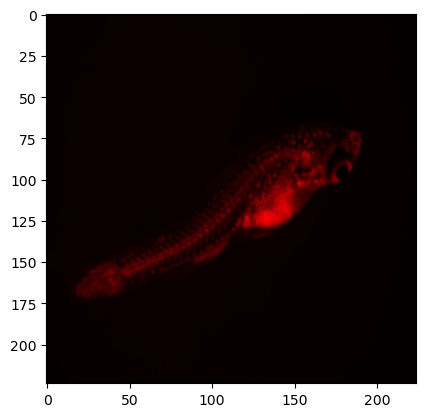

In [73]:
example = dataset[393]

print(example[0].shape)
plt.imshow(example[0].permute(1, 2, 0).cpu().numpy())

In [74]:
model.eval()
print(model(example[0].unsqueeze(0)).shape)

torch.Size([1, 128])


### Save the embedding vectors in a df

In [78]:
print(len(dataset))

1112


In [94]:
model.eval()
feature_matrix = {}
counter = 0

for image, image_name in dataset:
    embedding = model(image.unsqueeze(0))
    feature_matrix[image_name] = embedding.detach().cpu().numpy().reshape(128)

    if counter % 10 == 0:
        print(counter)

    counter += 1

0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
300
310
320
330
340
350
360
370
380
390
400
410
420
430
440
450
460
470
480
490
500
510
520
530
540
550
560
570
580
590
600
610
620
630
640
650
660
670
680
690
700
710
720
730
740
750
760
770
780
790
800
810
820
830
840
850
860
870
880
890
900
910
920
930
940
950
960
970
980
990
1000
1010
1020
1030
1040
1050
1060
1070
1080
1090
1100
1110


KeyError: 1112

In [1]:
print(len(feature_matrix))
print(feature_matrix)

NameError: name 'feature_matrix' is not defined

In [101]:
print(feature_matrix['PLATE 1 F2 VC_Female 95-1 F14 x Male 72-1 F14_A01.tif'])

[ -77.71443    -61.410744    29.089512    41.218525    30.065296
  -10.29204    410.0883     -33.349293  -723.1503    -232.67517
  300.89902     20.10732    190.17273    540.12695   -176.24693
   44.52819    100.90983    308.12897    -52.166943   175.80885
 -321.41968    217.52153    526.3035    -365.1253     318.0609
 -209.16046    220.87271    370.936      224.94162    351.8649
  -27.167477   508.67697   -480.5968    -278.52948      4.4324927
  206.6029    -134.35341   -406.53784    346.28265    256.88086
 -181.99242    485.08722   -220.7049    -424.36957   -271.82516
  198.51367    281.1529    -357.6786      77.26173     87.08338
  274.8931    -343.04498    577.7297     516.1294    -364.40228
  136.5843     401.59244    151.21652    -59.072773   373.43015
  377.18597    -21.082111  -476.3881    -143.25397   -324.05157
  202.96922   -438.98062   -364.07556   -109.75923   -419.75226
  173.96829    399.22427     22.354723    10.570647  -542.5288
 -136.3367     360.90564    512.31586   

In [98]:
feature_df = pd.DataFrame.from_dict(feature_matrix, orient='index')
feature_df

feature_df.to_csv("/nfs/research/birney/users/esther/medaka-img/features/convnet-ae-pytorch-medaka/amber-sweep-1-epoch500-feature_matrix.csv")

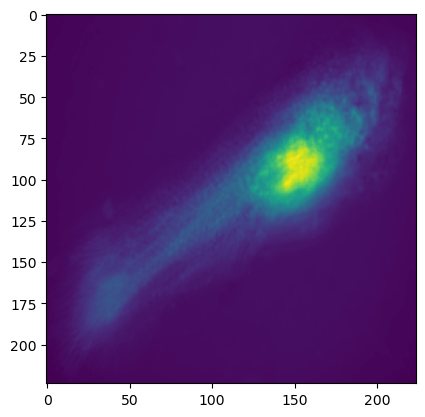

In [25]:
model.to(device)
model_output = model(train_example[0].reshape(-1, 224*224).to(device))

model_output = model_output.reshape(224, 224)
plt.imshow(model_output.cpu().detach().numpy())

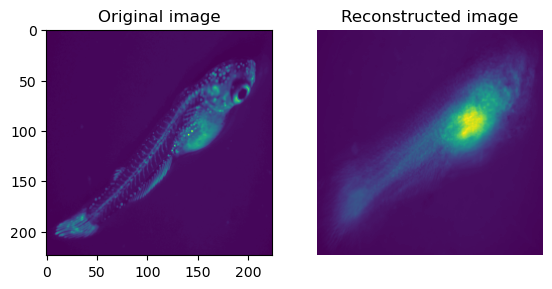

In [26]:
fig, axs = plt.subplots(1,2)

axs[0].imshow(train_example[0].permute(1, 2, 0).cpu().numpy())
axs[0].set_title('Original image')

axs[1].imshow(model_output.cpu().detach().numpy())
axs[1].set_title('Reconstructed image')
axs[1].axis('off')

plt.show()

In [ ]:
import IPython
app = IPython.Application.instance()
app.kernel.do_shutdown(True)

: 